# Trail Power - Power Study

This is a study that will use properties in the a Capella model to perform a study on the number of solar panels required to satisfy various a few usage scenarios.

Access the System Model that is in GitHUB folder with a python module "caplellambse" that can read and modify the SMW/Capella model content.

In [1]:
import capellambse
import ipywidgets as widgets
from IPython.core.display import HTML

resources = {
    "Trail_Power_for_Campgrounds": "Trail_Power_for_Campgrounds/Trail Power for Campgrounds",
}
path_to_model = "../Trail Power.aird"
model = capellambse.MelodyModel(path_to_model, resources=resources)

Display a diagram from the capella module with parameters being accessed.


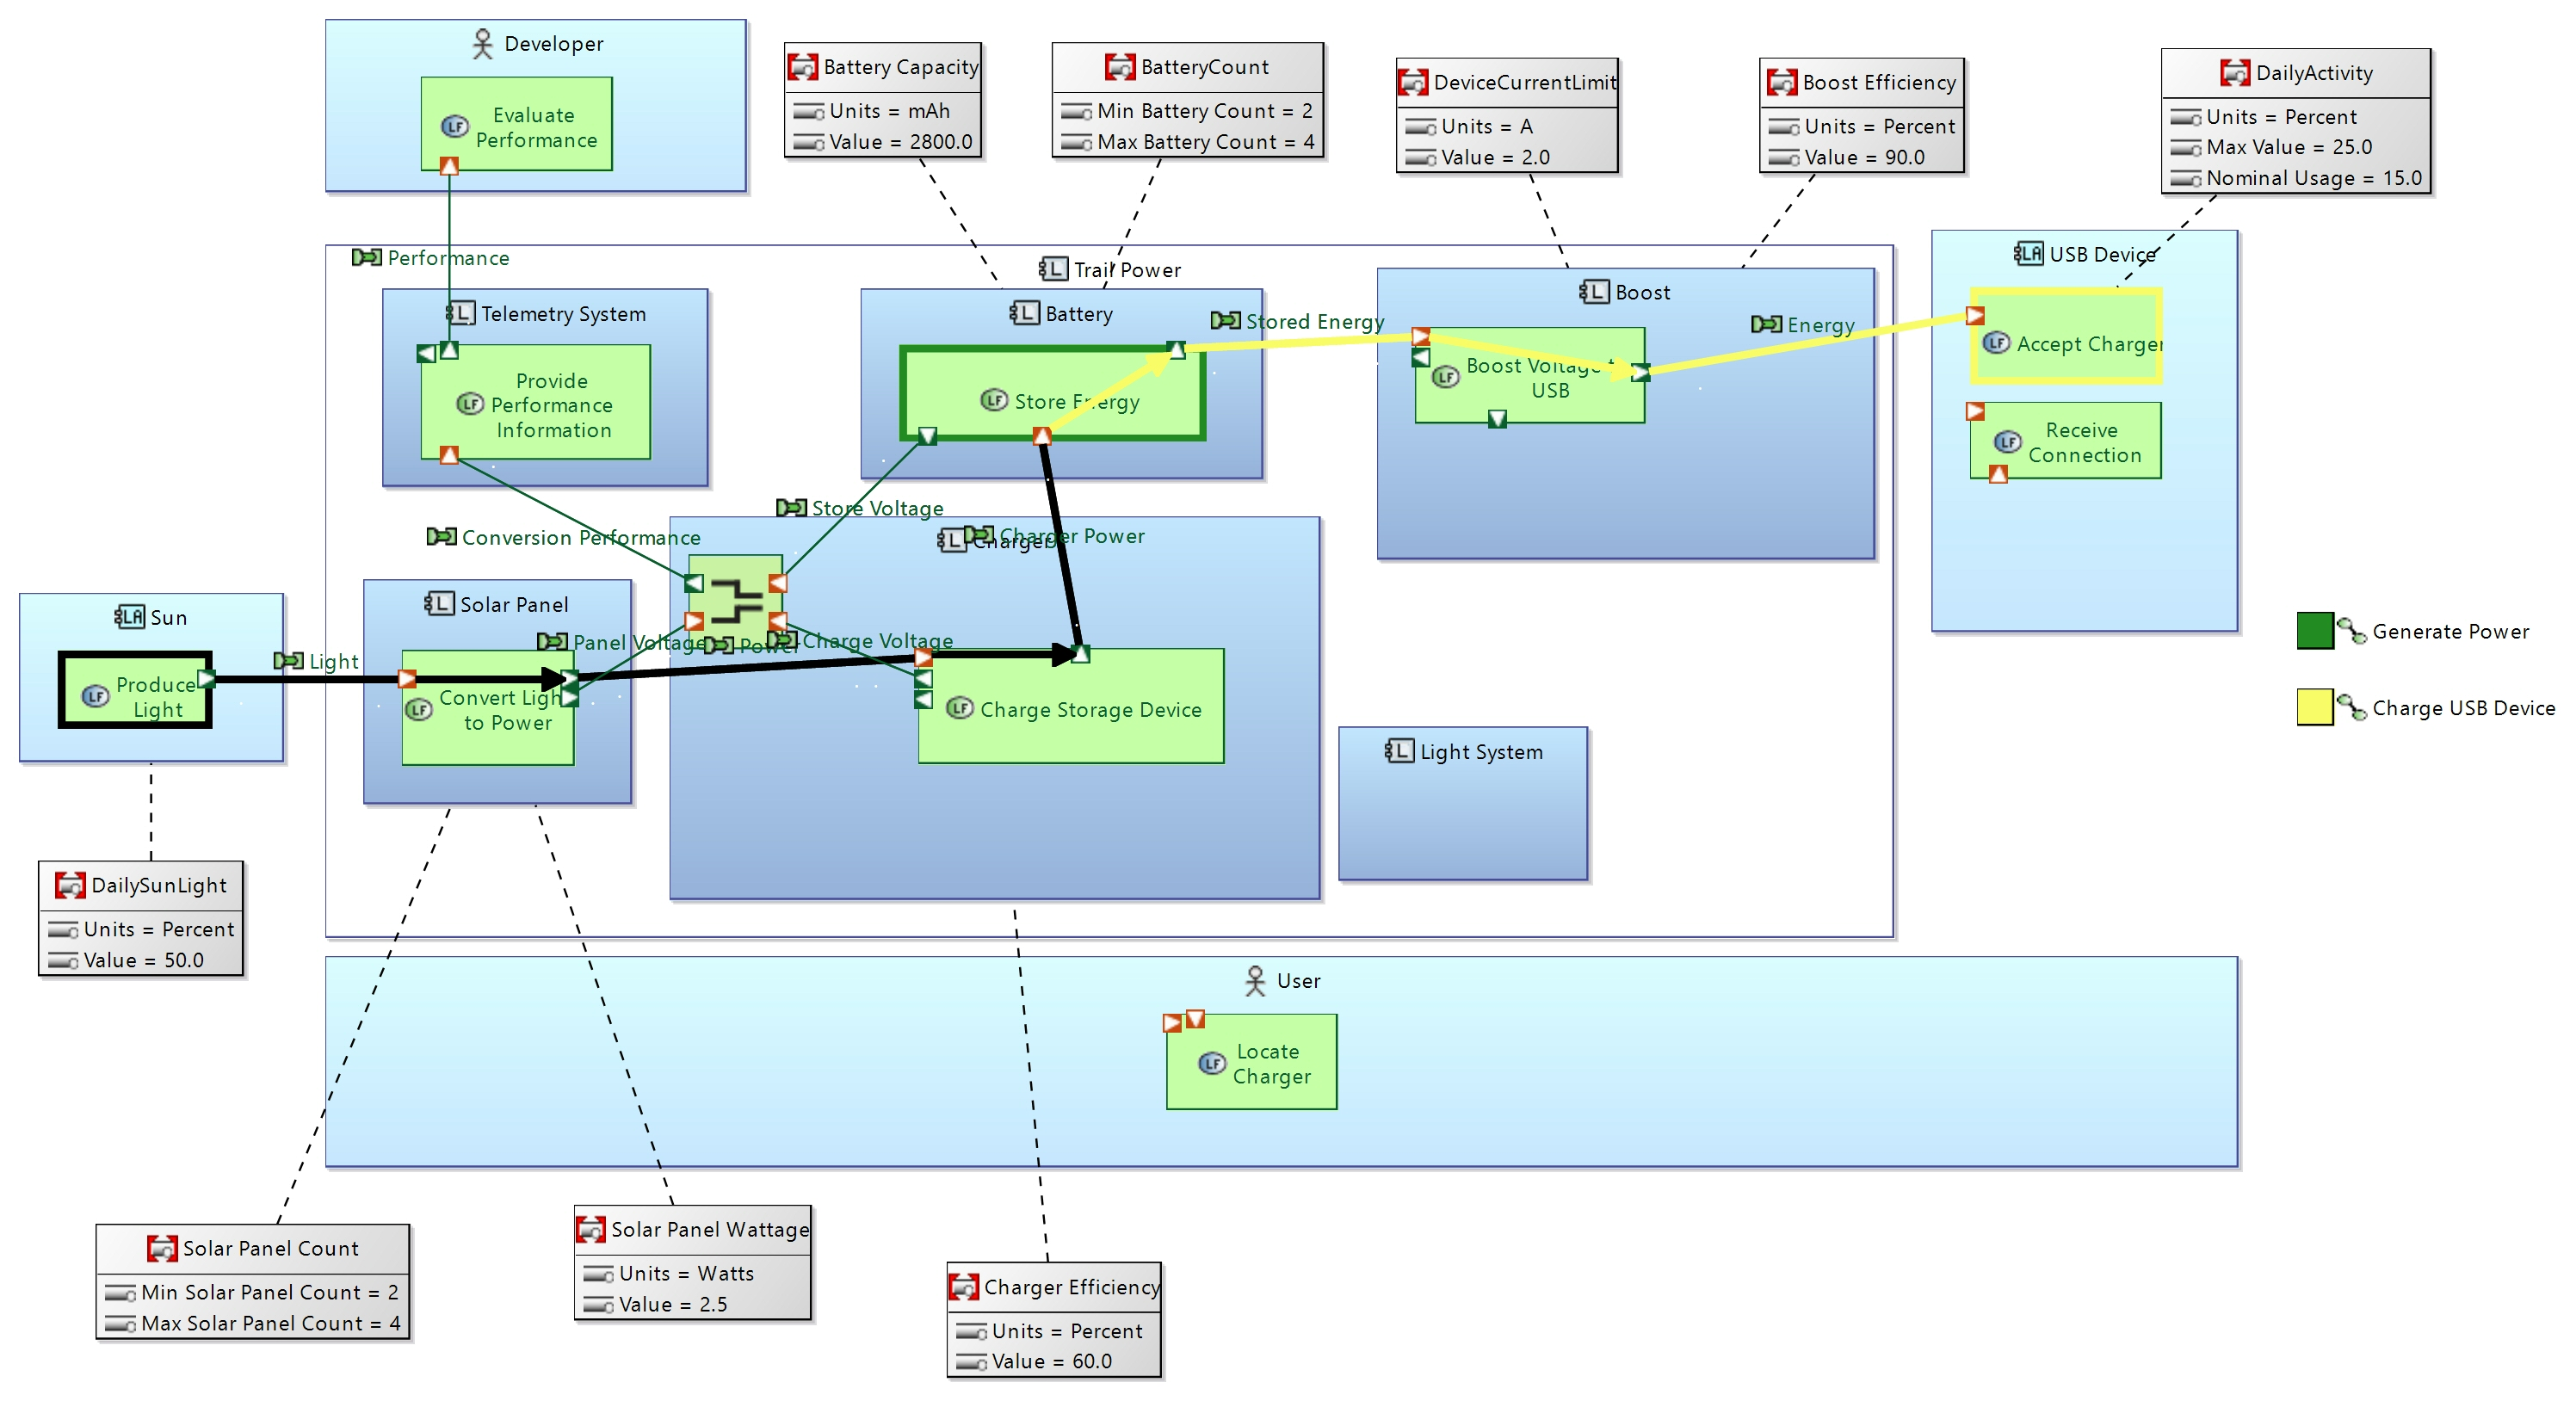

In [2]:
from IPython import display as diag_display
diag_display.Image("../Images/[LAB] Trail Power (Charge) Properties.jpg")


## Display all the parameters and respective components/functions in the logical architecture
The following is a report of all the parameters avialable to be used. 

In [3]:
la_model = model.la 

for function in la_model.all_functions:
    for pvg in  function.applied_property_value_groups :
        for pv in  pvg.property_values:
            print("LogicalFunction=",'"' +function.name+ '"',"property_value_groups=",'"' +pvg.name+ '"','"Property Name"=','"' +pv.name+ '"','"Value"=',pv.value )

for component in la_model.all_components:
    for pvg in  component.applied_property_value_groups :
        for pv in  pvg.property_values:
            print("LogicalComponents=",'"' +component.name+ '"',"property_value_groups=",'"' +pvg.name+ '"','Property Name=','"' + pv.name + '"','Value=',pv.value  )

  

LogicalFunction= "Accept Charger" property_value_groups= "DailyActivity" "Property Name"= "Units" "Value"= Percent
LogicalFunction= "Accept Charger" property_value_groups= "DailyActivity" "Property Name"= "Max Value" "Value"= 25.0
LogicalFunction= "Accept Charger" property_value_groups= "DailyActivity" "Property Name"= "Nominal Usage" "Value"= 15.0
LogicalComponents= "Boost" property_value_groups= "Boost Efficiency" Property Name= "Units" Value= Percent
LogicalComponents= "Boost" property_value_groups= "Boost Efficiency" Property Name= "Value" Value= 90.0
LogicalComponents= "Boost" property_value_groups= "DeviceCurrentLimit" Property Name= "Units" Value= A
LogicalComponents= "Boost" property_value_groups= "DeviceCurrentLimit" Property Name= "Value" Value= 2.0
LogicalComponents= "Battery" property_value_groups= "Battery Capacity" Property Name= "Units" Value= mAh
LogicalComponents= "Battery" property_value_groups= "Battery Capacity" Property Name= "Value" Value= 2800.0
LogicalComponents

The following code can be used in the study to retrive the value from the model to use in the study.

your_variable = model.search("LogicalFunction").by_name("Name of Function").property_value_groups["Name of property Value Group"]["Name of Property"])

You can see an example below.

In [4]:
print( "Battery Size" , model.search("LogicalComponent").by_name("Battery").property_value_groups["Battery Capacity"]["Value"] ,\
"Units:" ,model.search("LogicalComponent").by_name("Battery").property_value_groups["Battery Capacity"]["Units"])

Battery Size 2800.0 Units: mAh


In [5]:
from sympy import symbols, Piecewise, sin, pi, Heaviside, integrate, And, simplify
import numpy as np

import sympy as sp
import pandas as pd 
import plotly.express as px
from IPython.display import Markdown
from scipy.integrate import simpson


In [6]:
t = symbols('t')
period = symbols('period')


In [7]:


# Define the pulse function
def pulse(t, start, width):
    return Piecewise(
        (1, And(t >= start, t < start + width)),
        (0, True)
    )

# Define a pulse train that operates over a specified time length
def pulse_train(t, pulse_width, period, total_time):
    # Calculate the number of pulses that fit within the total time
    num_pulses = int(total_time // period)
    
    # Generate the pulse train expression
    return sum(pulse(t, start=i*period, width=pulse_width) for i in range(num_pulses))


def power_generator(t, pulse_width, period, total_time,  SP_Power, charger_eff ):
    return (charger_eff/100) *SP_Power * pulse_train(t, pulse_width, period, total_time)
    

def battery_load(t,  pulse_width, period, total_time, USB_Current,Boost_Efficiency):
    return USB_Current * 5.0  * ((1 - Boost_Efficiency/100)+1) * pulse_train(t, pulse_width, period, total_time)
    


In [8]:
sun_period_value = model.search("LogicalComponent").by_name("Sun").property_value_groups["DailySunLight"]["Value"] # Example period of 12 hours for .50
load_period_value = model.search("LogicalFunction").by_name("Accept Charger").property_value_groups["DailyActivity"]["Nominal Usage"]  # Example period of 12 hours for .50
panel_power = model.search("LogicalComponent").by_name("Solar Panel").property_value_groups["Solar Panel Wattage"]["Value"] 
solar_panel_count_min = model.search("LogicalComponent").by_name("Solar Panel").property_value_groups["Solar Panel Count"]["Min Solar Panel Count"]
solar_panel_count_max = model.search("LogicalComponent").by_name("Solar Panel").property_value_groups["Solar Panel Count"]["Max Solar Panel Count"]
boost_efficiency = model.search("LogicalComponent").by_name("Boost").property_value_groups["Boost Efficiency"]["Value"]
boost_current_limit = model.search("LogicalComponent").by_name("Boost").property_value_groups["DeviceCurrentLimit"]["Value"]
charger_eff =model.search("LogicalComponent").by_name("Charger").property_value_groups["Charger Efficiency"]["Value"]
battery_capacity =model.search("LogicalComponent").by_name("Battery").property_value_groups["Battery Capacity"]["Value"]/1000 
battery_count_min = model.search("LogicalComponent").by_name("Battery").property_value_groups["BatteryCount"]["Min Battery Count"]
battery_count_max = model.search("LogicalComponent").by_name("Battery").property_value_groups["BatteryCount"]["Max Battery Count"]

display(Markdown(f"# Formula for Battery Charge Calculations and constant values for Study"))

display(Markdown(f" $$SunPeriod= {sun_period_value} $$"))
display(Markdown(f" $$LoadPeriod= {load_period_value} $$"))
display(Markdown(f" $$BoostEfficiency = {boost_efficiency } $$"))
display(Markdown(f" $$USBCurrent = {boost_current_limit } $$"))
display(Markdown(f" $$PowerGenerator(t) = PulseTrain(t,SunPeriod* 24/100,24,24*7)*SolarPanelPower * ChargerEfficiency/100 $$"))
display(Markdown(f" $$BatteryLoad(t) = PulsePTrain(t,LoadPeriod * 24/100,24 , 24*7) * USBCurrent * ((1 - BoostEfficiency/100)+1)   $$"))
display(Markdown(f" $$BatteryCharge(t) = PowerGenerator(t) - BatteryLoad(t)  $$"))
display(Markdown(f" $$BatteryCharge  = \int_{0}^{t} BatteryCharge(t)\, dt$$"))

# Formula for Battery Charge Calculations and constant values for Study

 $$SunPeriod= 50.0 $$

 $$LoadPeriod= 15.0 $$

 $$BoostEfficiency = 90.0 $$

 $$USBCurrent = 2.0 $$

 $$PowerGenerator(t) = PulseTrain(t,SunPeriod* 24/100,24,24*7)*SolarPanelPower * ChargerEfficiency/100 $$

 $$BatteryLoad(t) = PulsePTrain(t,LoadPeriod * 24/100,24 , 24*7) * USBCurrent * ((1 - BoostEfficiency/100)+1)   $$

 $$BatteryCharge(t) = PowerGenerator(t) - BatteryLoad(t)  $$

 $$BatteryCharge  = \int_0^t BatteryCharge(t)\, dt$$

The following study will look at the various configuations of battery count and panel count and generate graphs of Battery Charge.

# Trade Study one with following inputs

 $$PanelCount =  2 $$

 $$BatteryCount =  2 $$

 $$SolarPanelPower= PanelPower * PanelCount =  2.5 * 2 $$

 $$BatteryCapacity = BatteryCapactiy * BatteryCount = 2.8 * 2 AH $$

Numerical Integration Result: 4.8


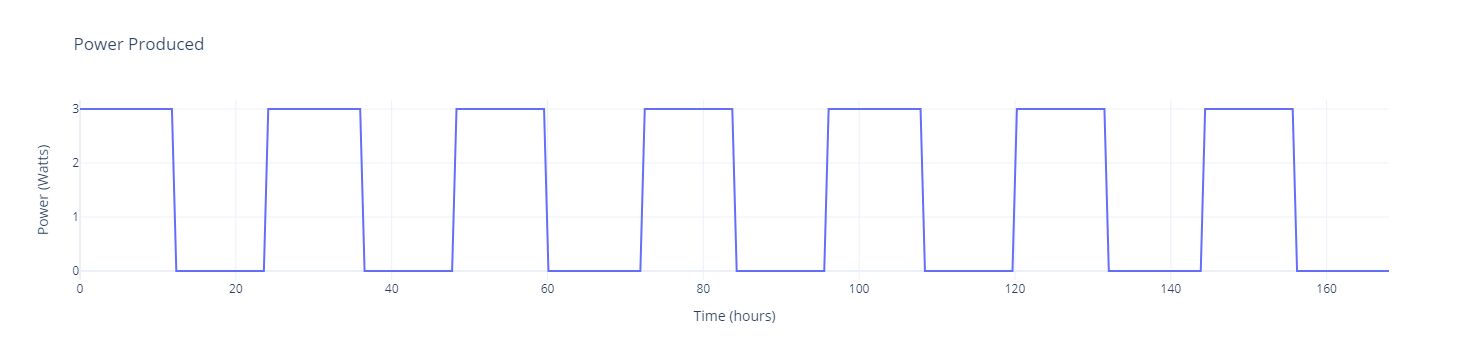

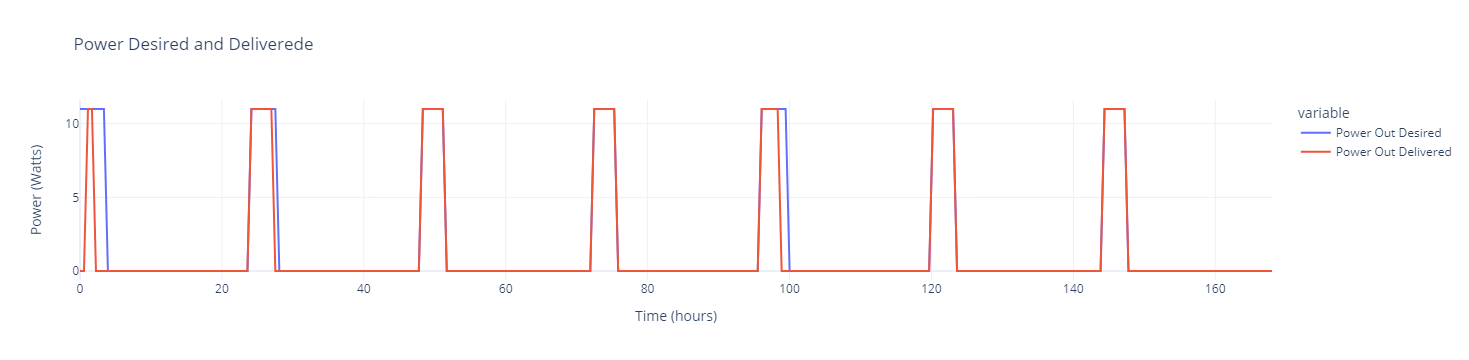

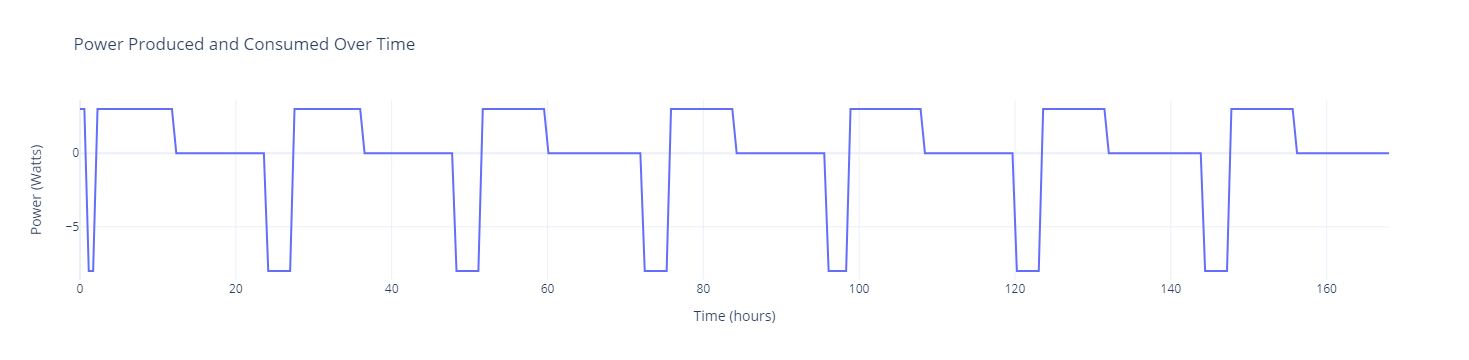

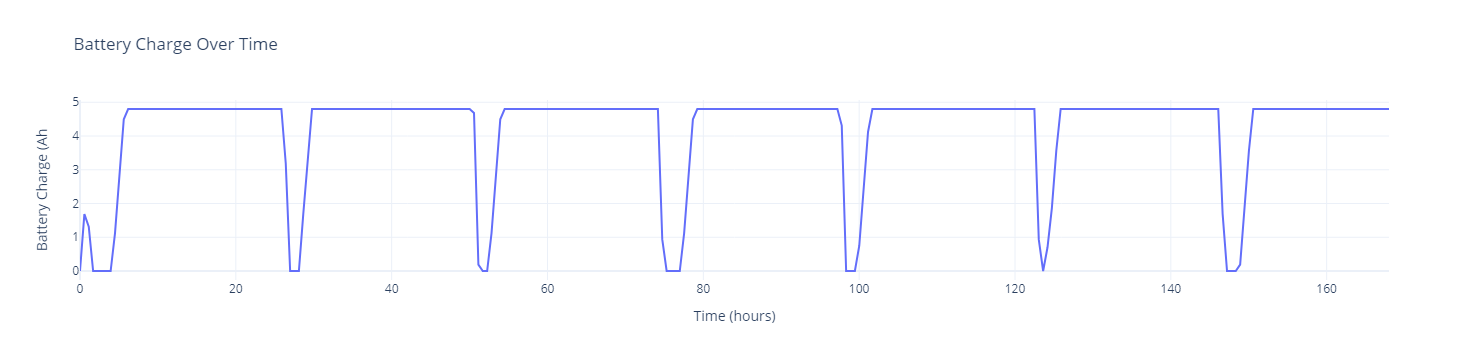

# Trade Study one with following inputs

 $$PanelCount =  2 $$

 $$BatteryCount =  3 $$

 $$SolarPanelPower= PanelPower * PanelCount =  2.5 * 2 $$

 $$BatteryCapacity = BatteryCapactiy * BatteryCount = 2.8 * 3 AH $$

Numerical Integration Result: 5.8


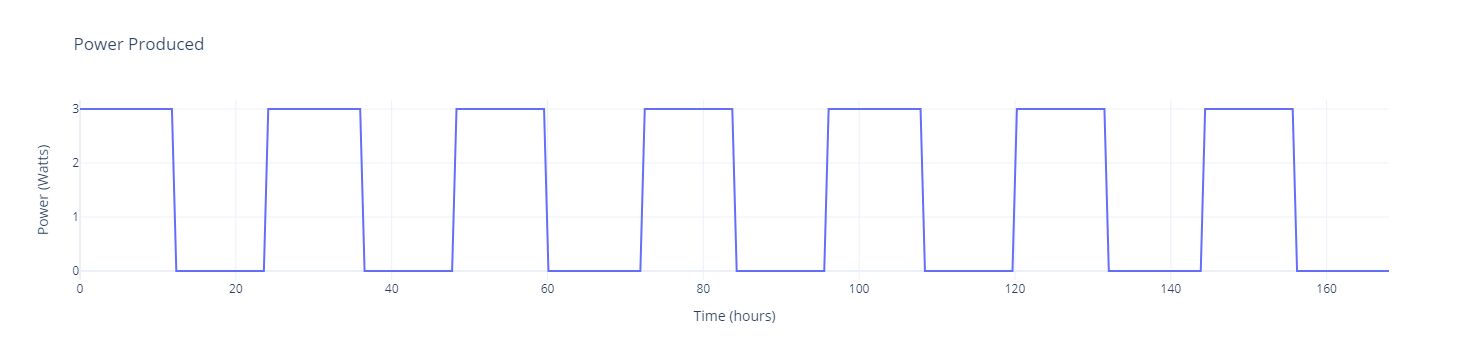

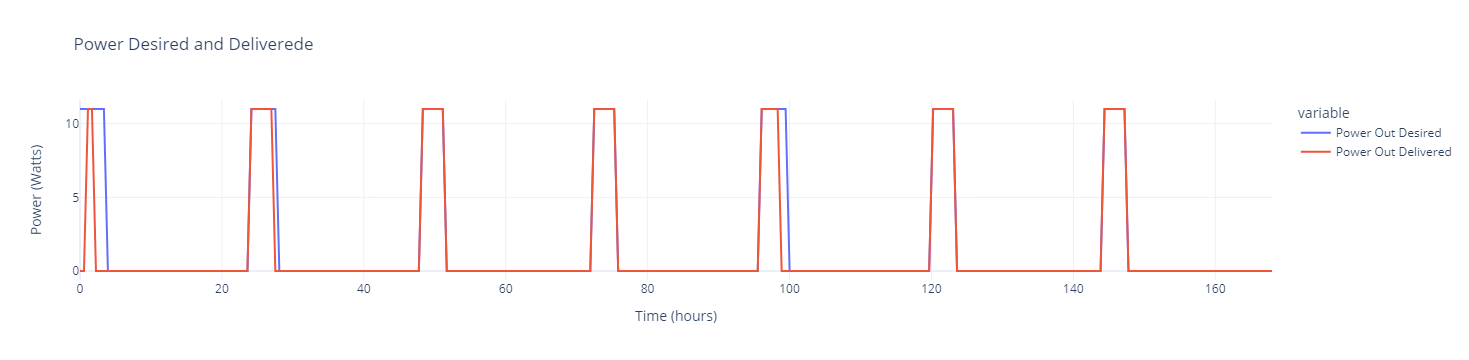

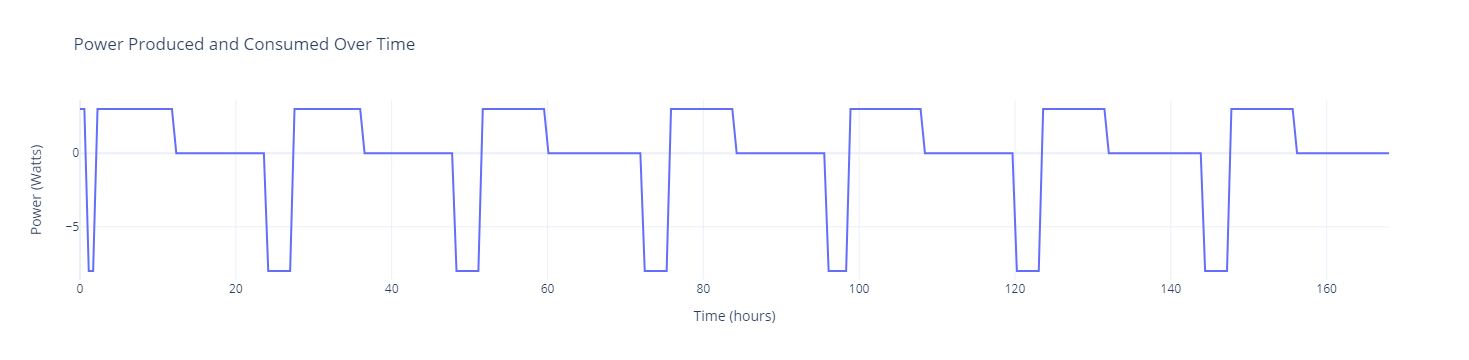

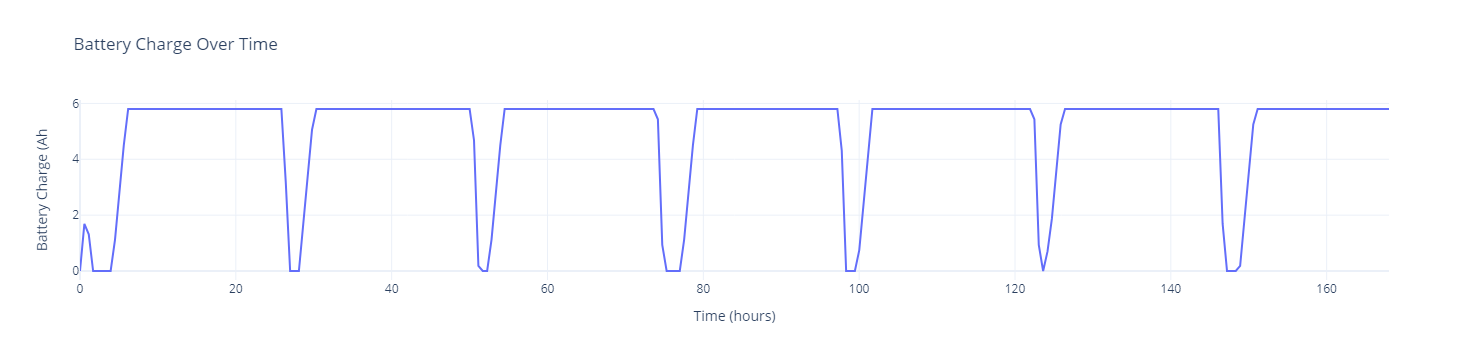

# Trade Study one with following inputs

 $$PanelCount =  2 $$

 $$BatteryCount =  4 $$

 $$SolarPanelPower= PanelPower * PanelCount =  2.5 * 2 $$

 $$BatteryCapacity = BatteryCapactiy * BatteryCount = 2.8 * 4 AH $$

Numerical Integration Result: 6.8


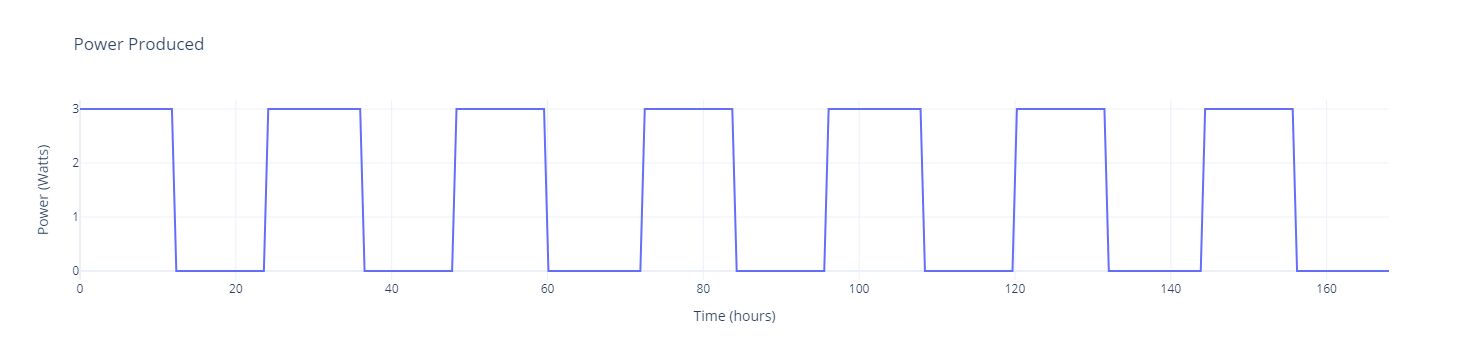

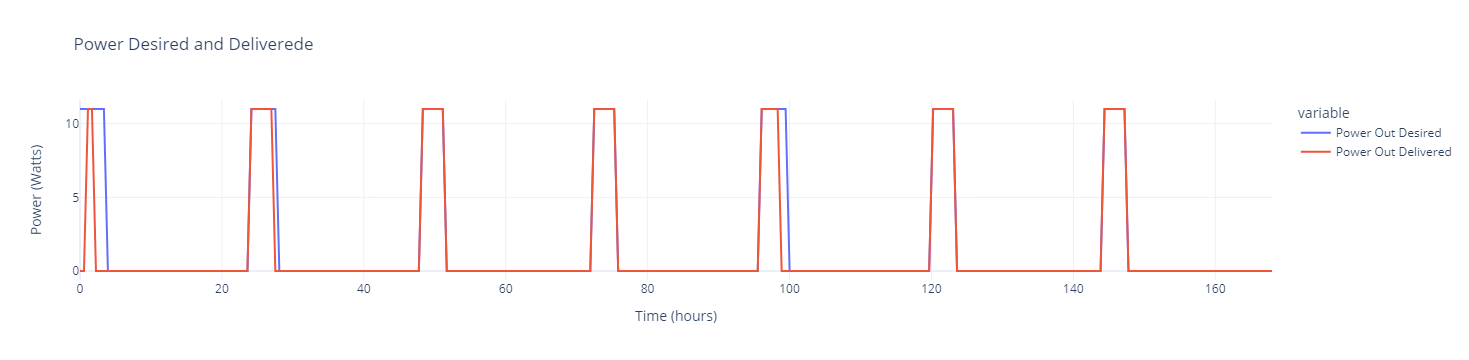

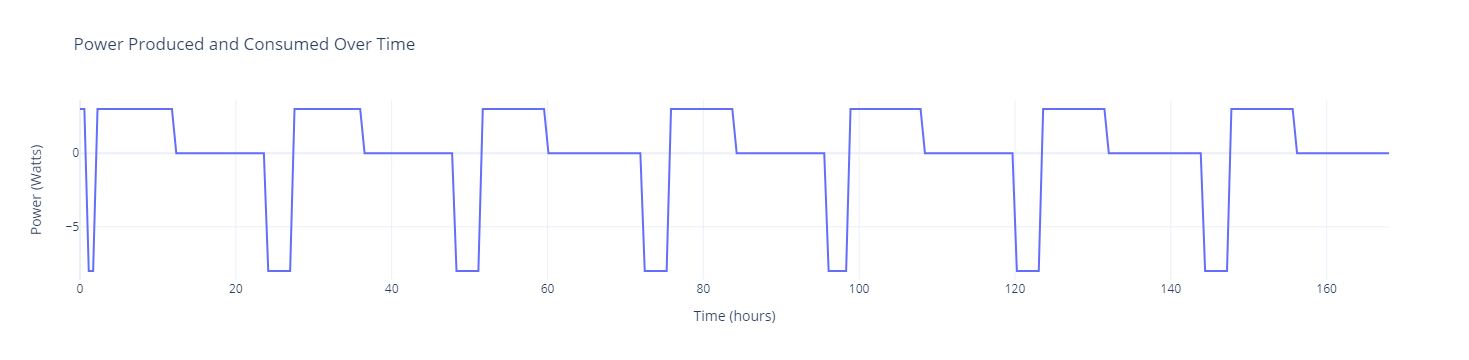

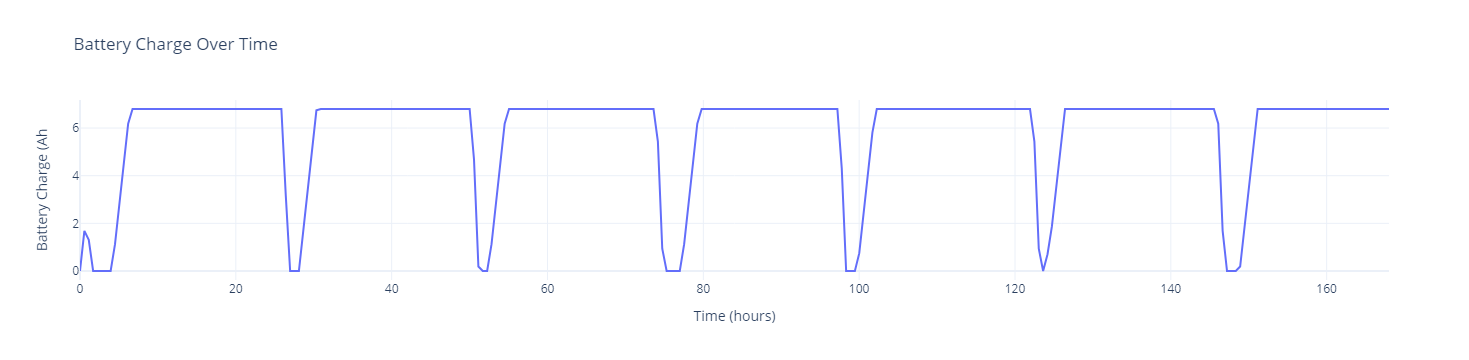

# Trade Study one with following inputs

 $$PanelCount =  3 $$

 $$BatteryCount =  2 $$

 $$SolarPanelPower= PanelPower * PanelCount =  2.5 * 3 $$

 $$BatteryCapacity = BatteryCapactiy * BatteryCount = 2.8 * 2 AH $$

Numerical Integration Result: 4.8


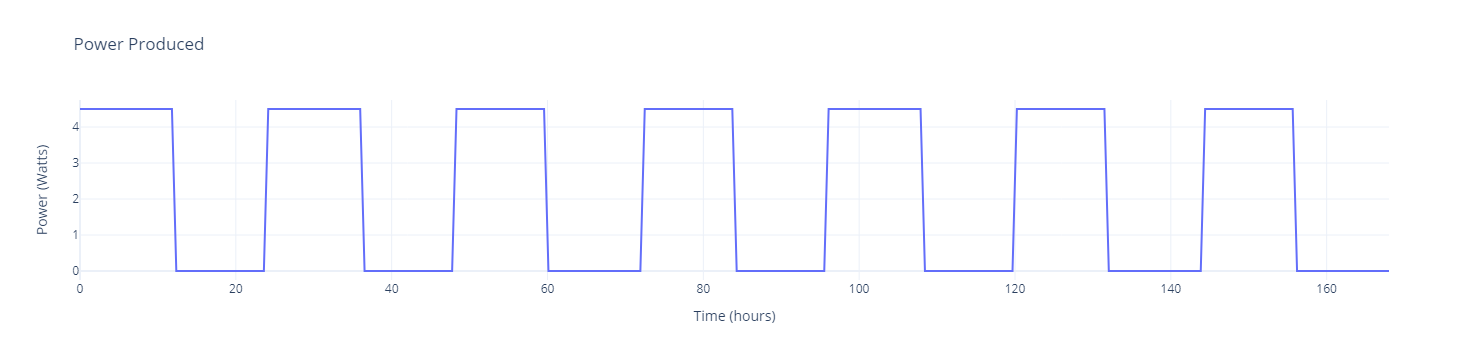

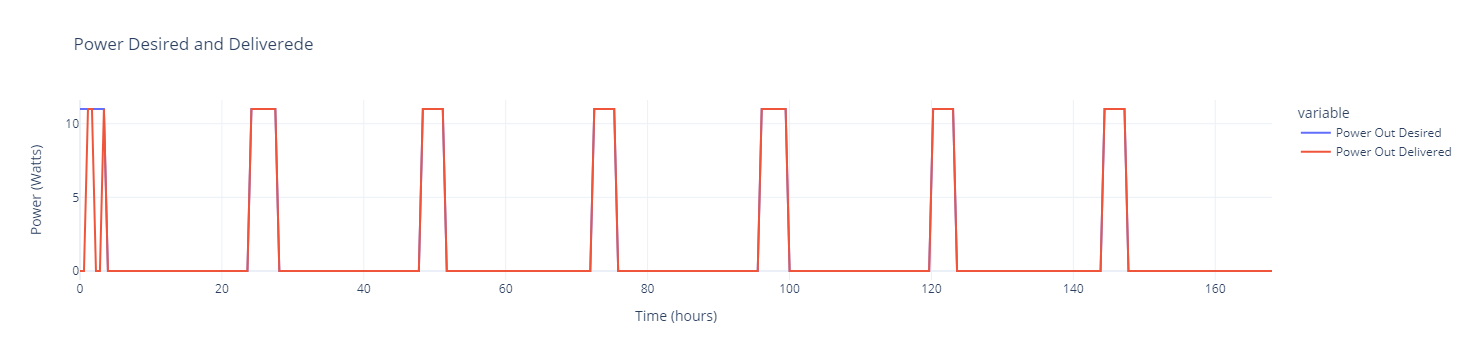

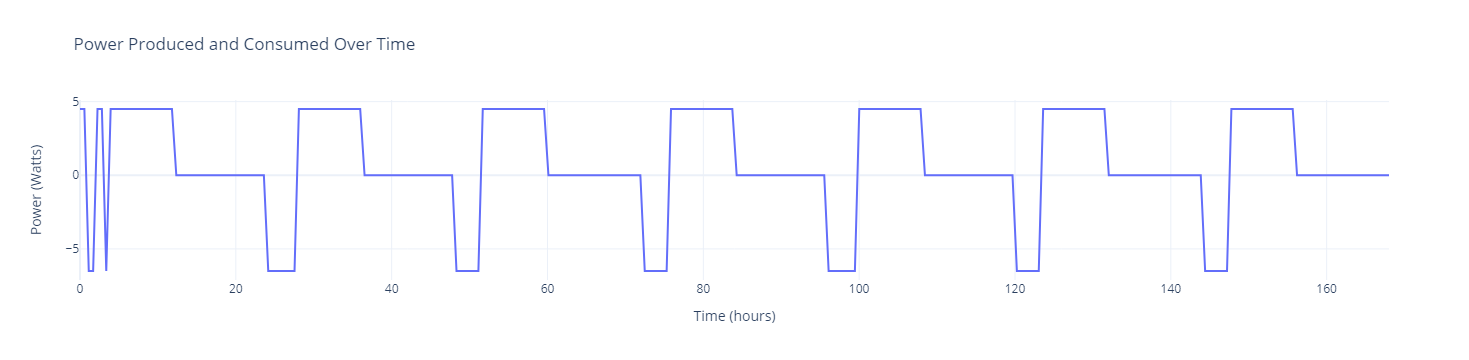

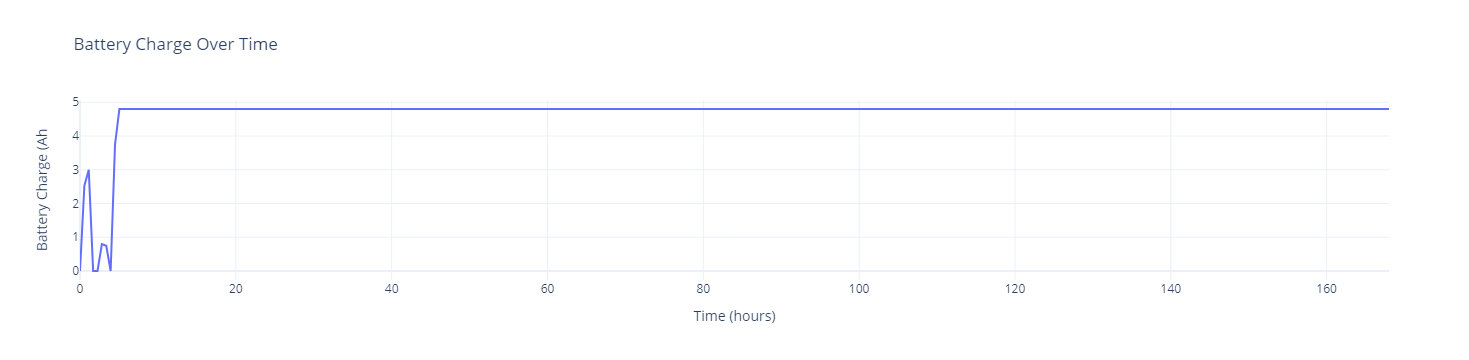

# Trade Study one with following inputs

 $$PanelCount =  3 $$

 $$BatteryCount =  3 $$

 $$SolarPanelPower= PanelPower * PanelCount =  2.5 * 3 $$

 $$BatteryCapacity = BatteryCapactiy * BatteryCount = 2.8 * 3 AH $$

Numerical Integration Result: 5.8


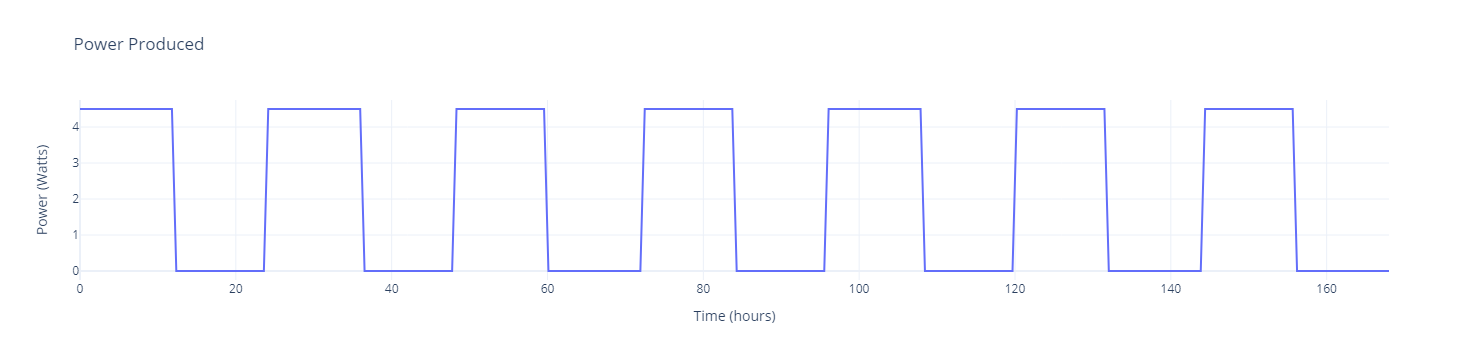

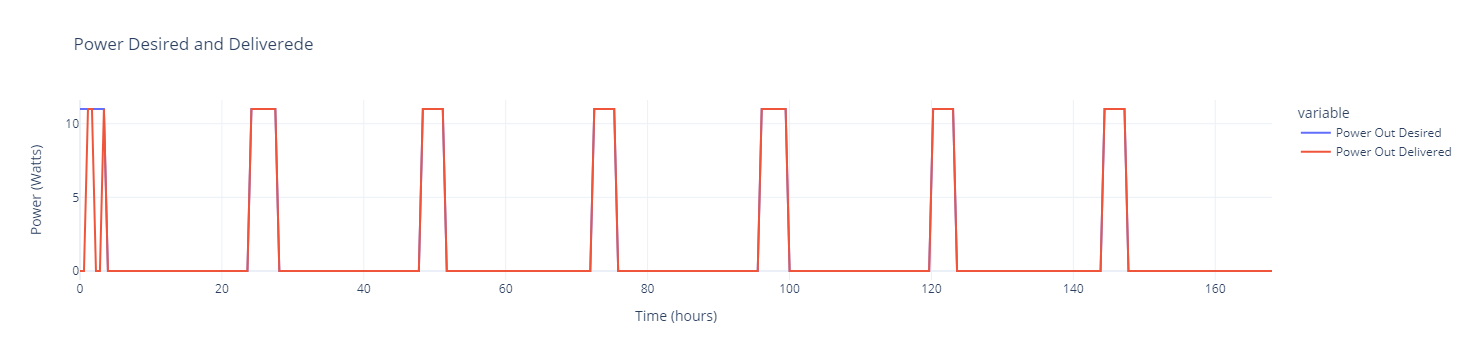

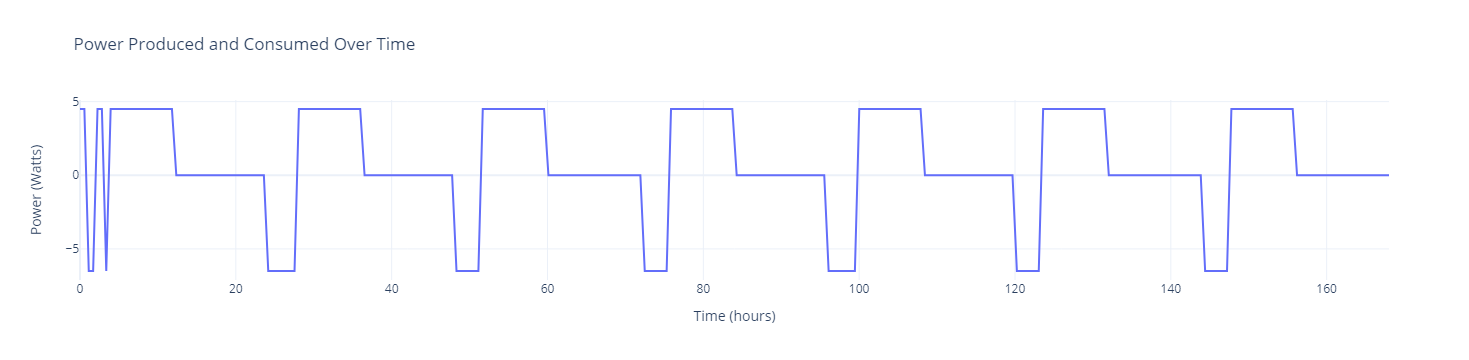

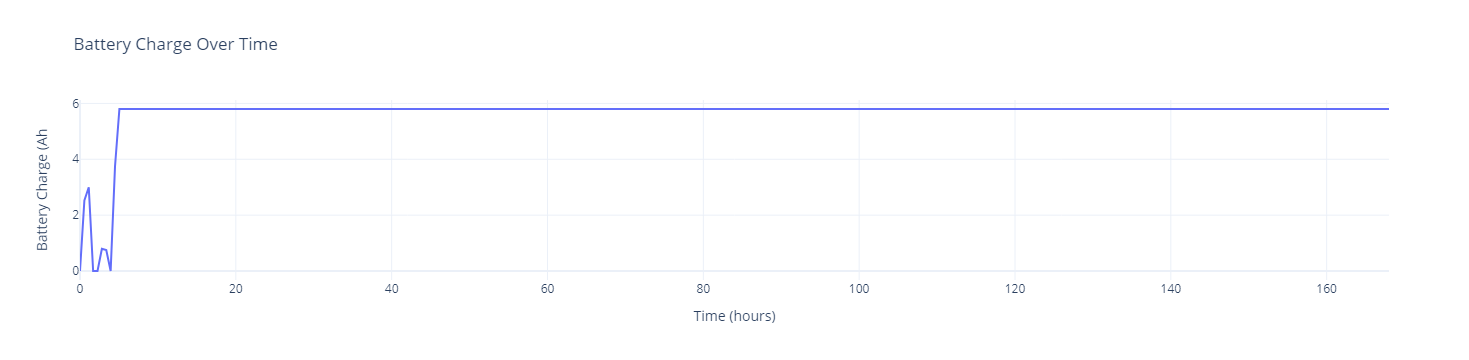

# Trade Study one with following inputs

 $$PanelCount =  3 $$

 $$BatteryCount =  4 $$

 $$SolarPanelPower= PanelPower * PanelCount =  2.5 * 3 $$

 $$BatteryCapacity = BatteryCapactiy * BatteryCount = 2.8 * 4 AH $$

Numerical Integration Result: 6.8


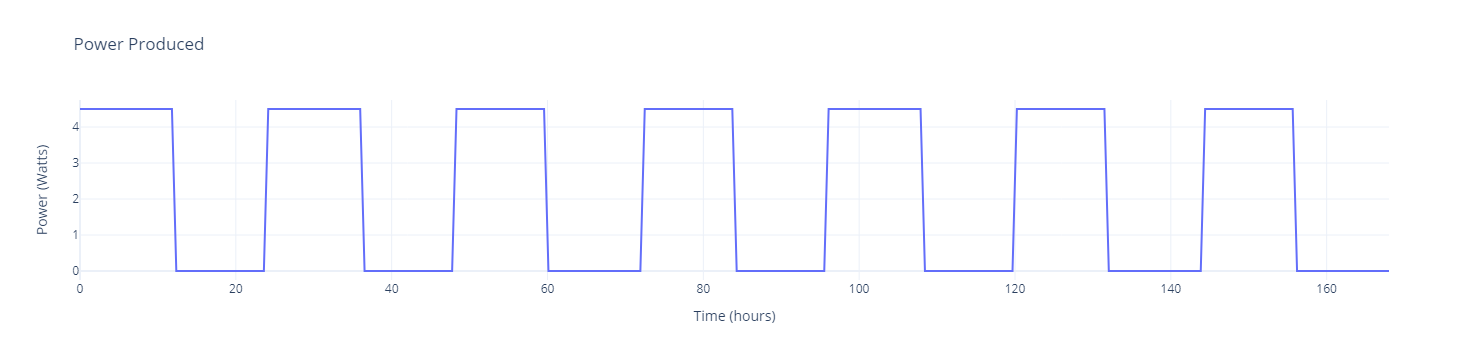

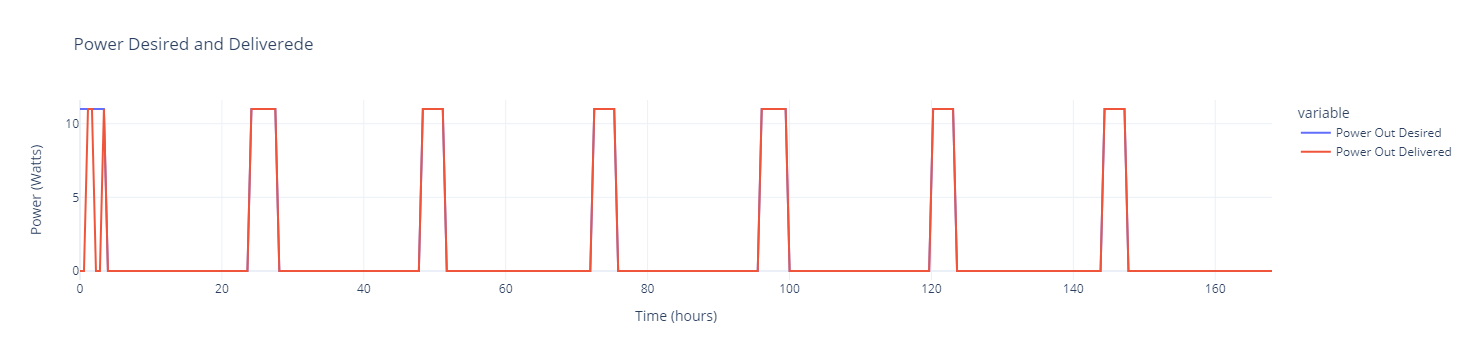

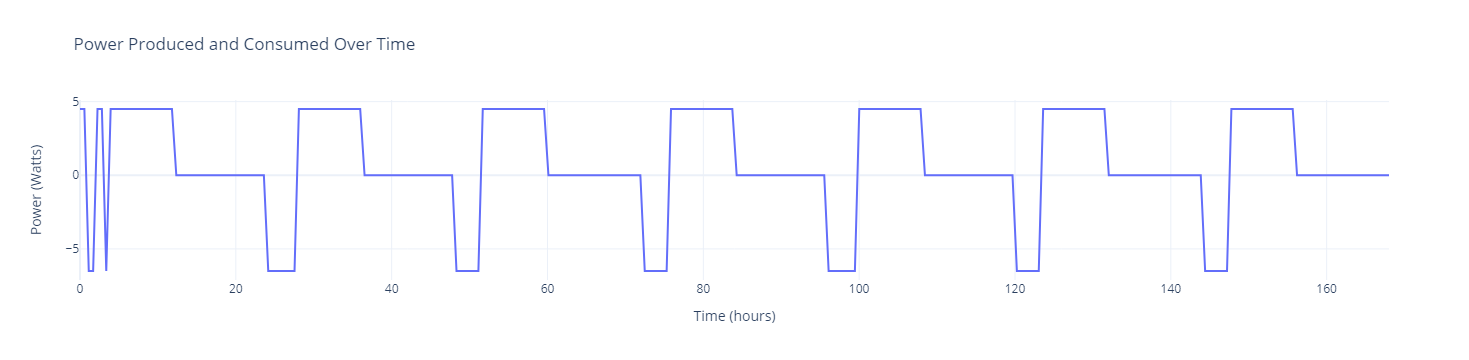

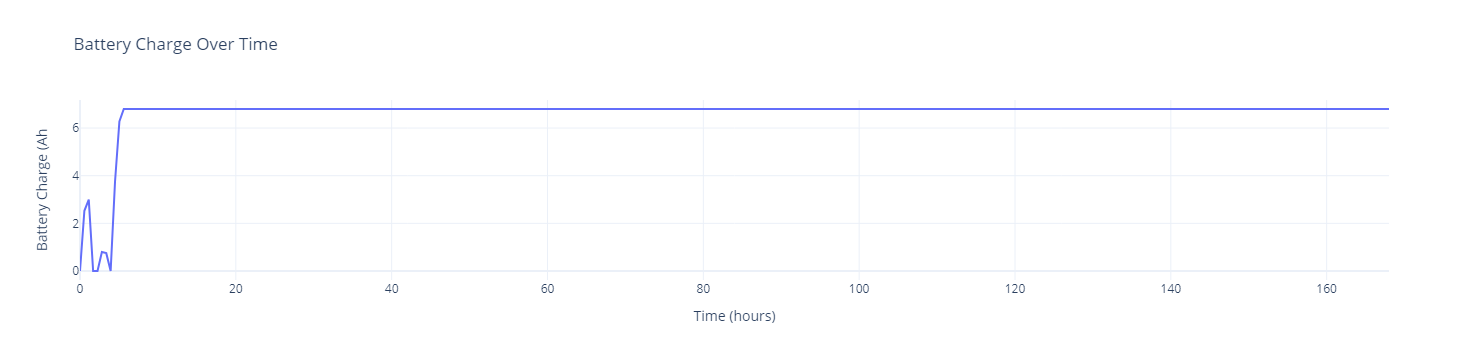

# Trade Study one with following inputs

 $$PanelCount =  4 $$

 $$BatteryCount =  2 $$

 $$SolarPanelPower= PanelPower * PanelCount =  2.5 * 4 $$

 $$BatteryCapacity = BatteryCapactiy * BatteryCount = 2.8 * 2 AH $$

Numerical Integration Result: 4.8


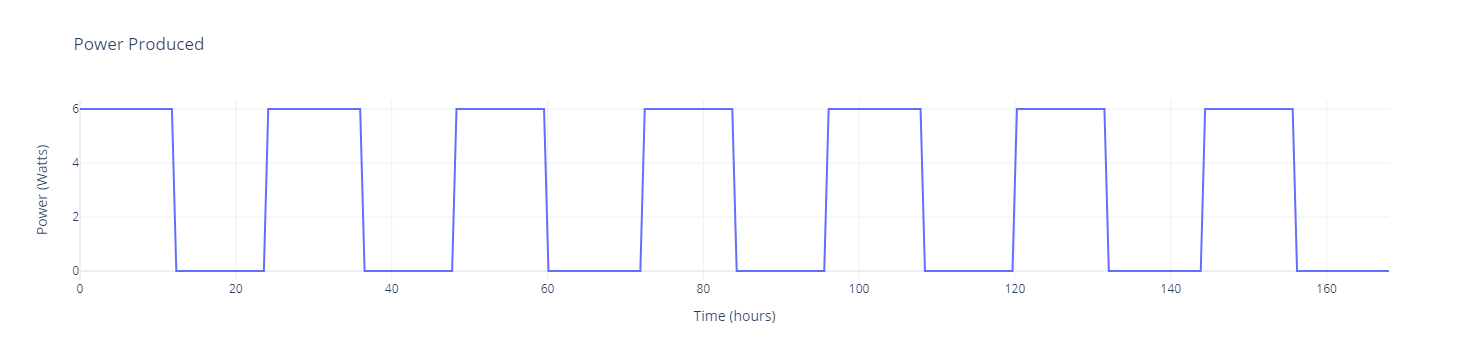

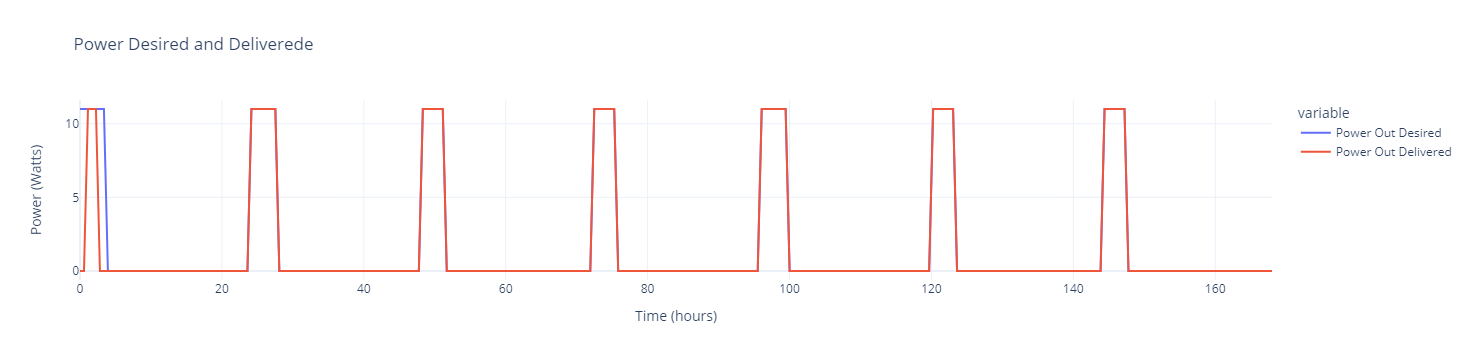

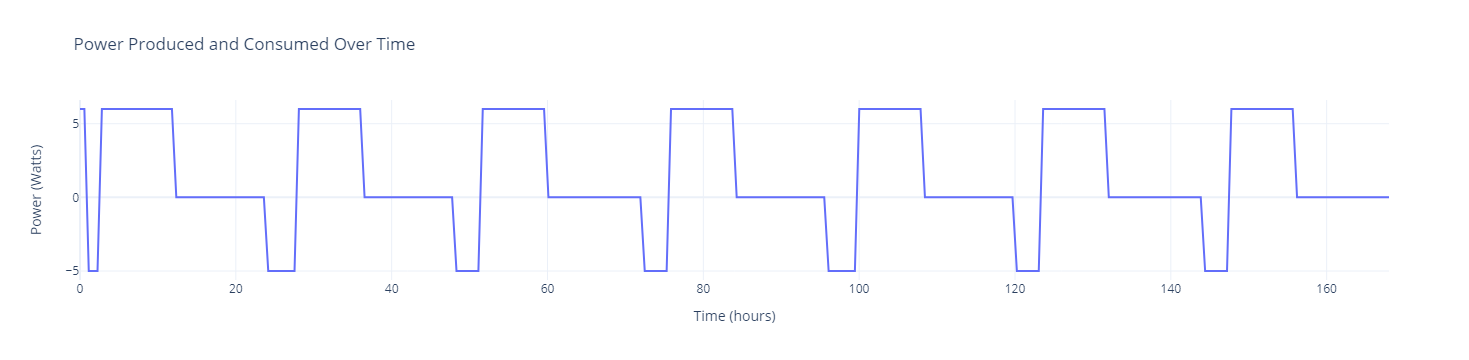

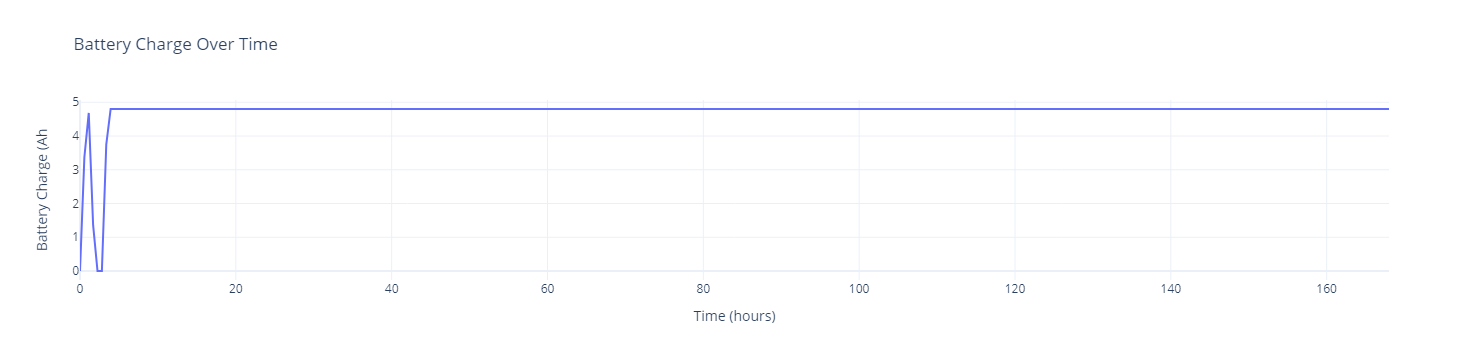

# Trade Study one with following inputs

 $$PanelCount =  4 $$

 $$BatteryCount =  3 $$

 $$SolarPanelPower= PanelPower * PanelCount =  2.5 * 4 $$

 $$BatteryCapacity = BatteryCapactiy * BatteryCount = 2.8 * 3 AH $$

Numerical Integration Result: 5.8


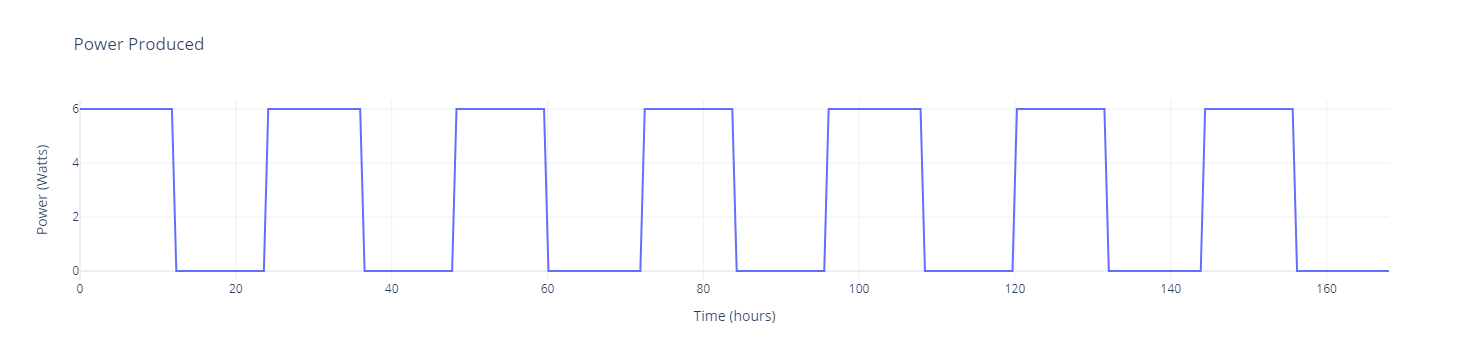

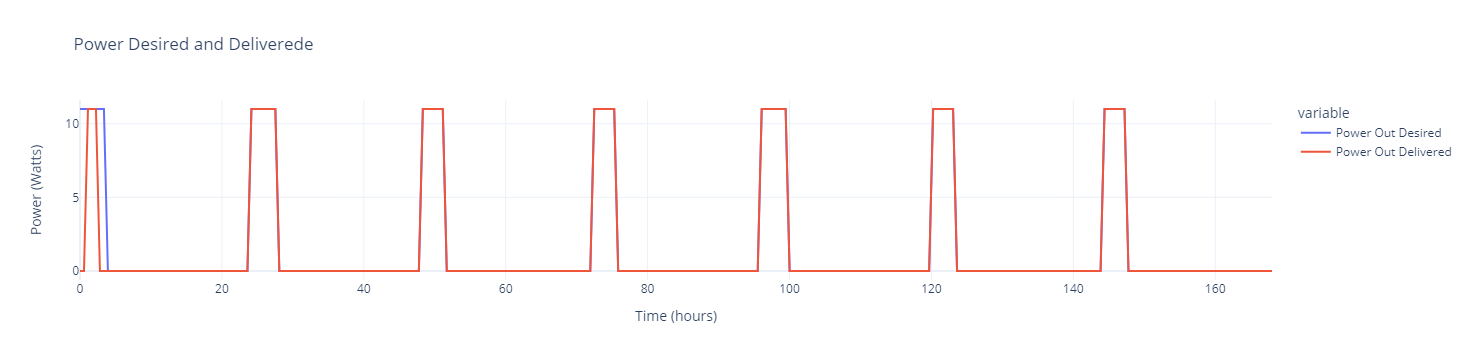

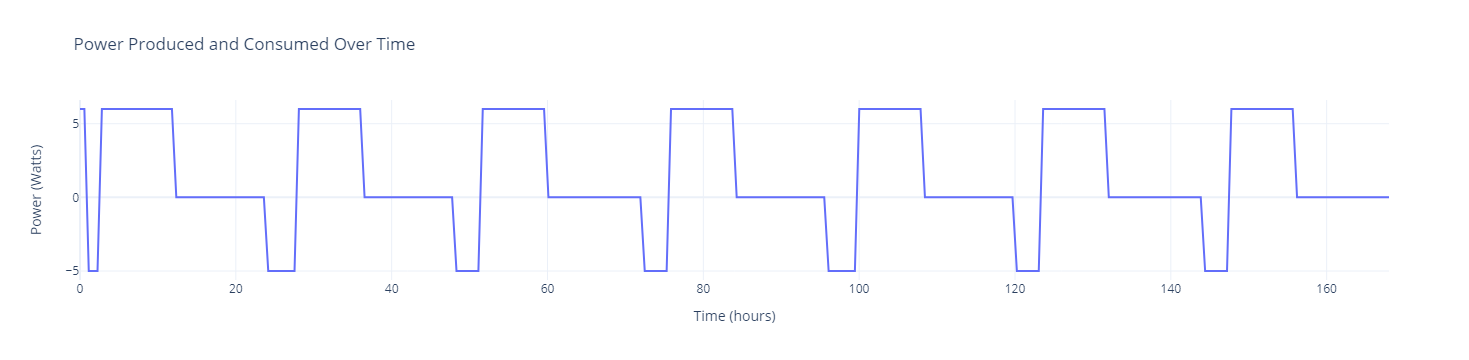

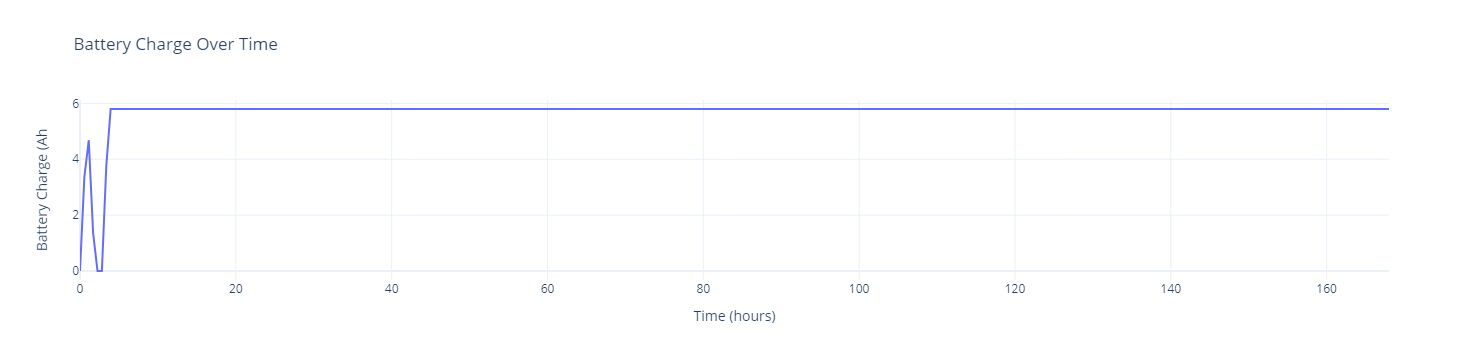

# Trade Study one with following inputs

 $$PanelCount =  4 $$

 $$BatteryCount =  4 $$

 $$SolarPanelPower= PanelPower * PanelCount =  2.5 * 4 $$

 $$BatteryCapacity = BatteryCapactiy * BatteryCount = 2.8 * 4 AH $$

Numerical Integration Result: 6.8


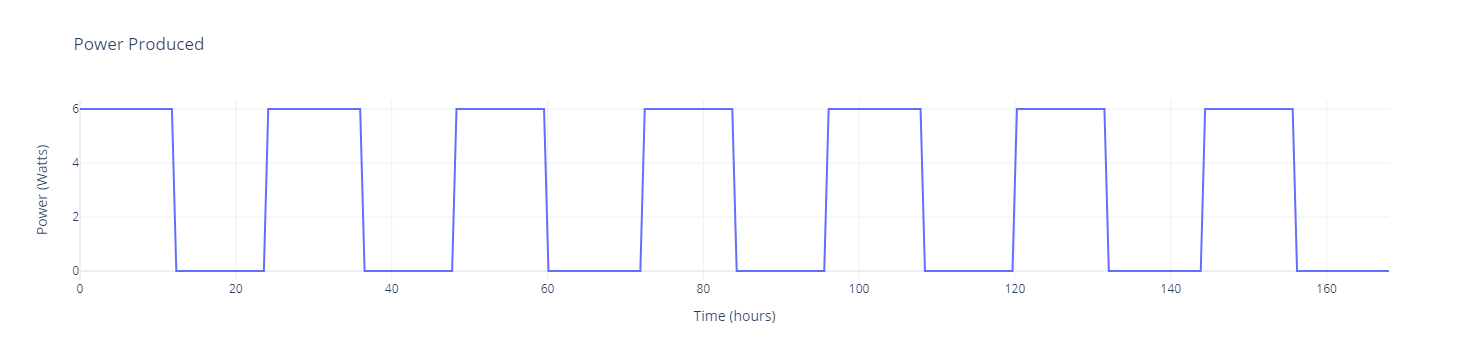

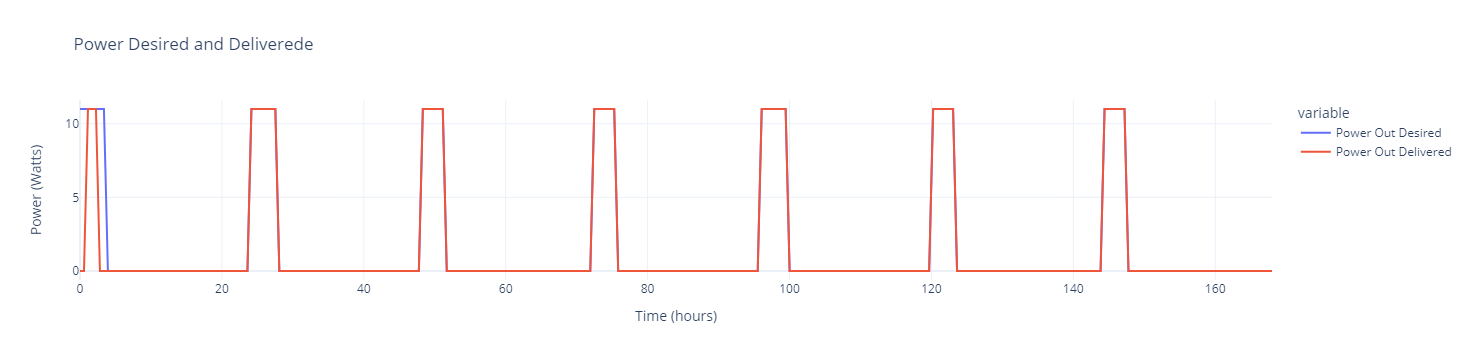

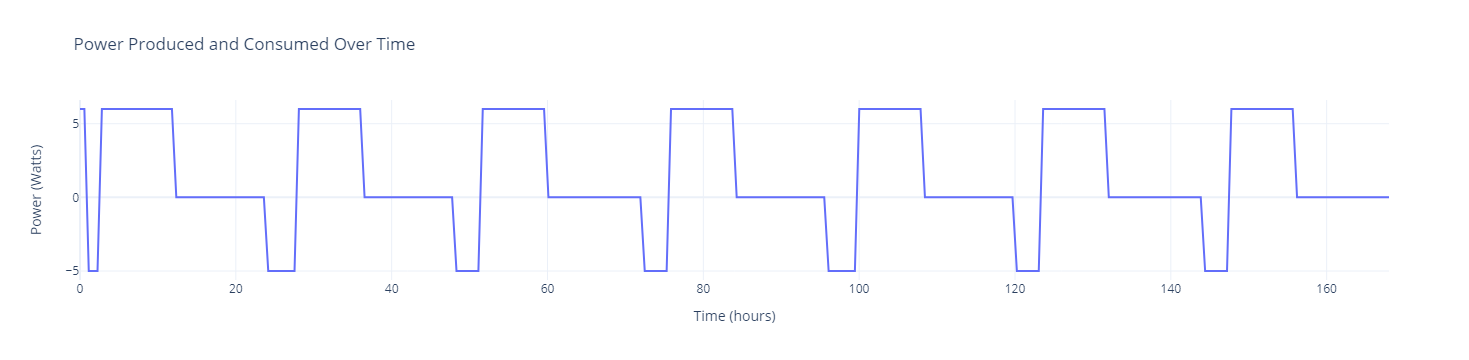

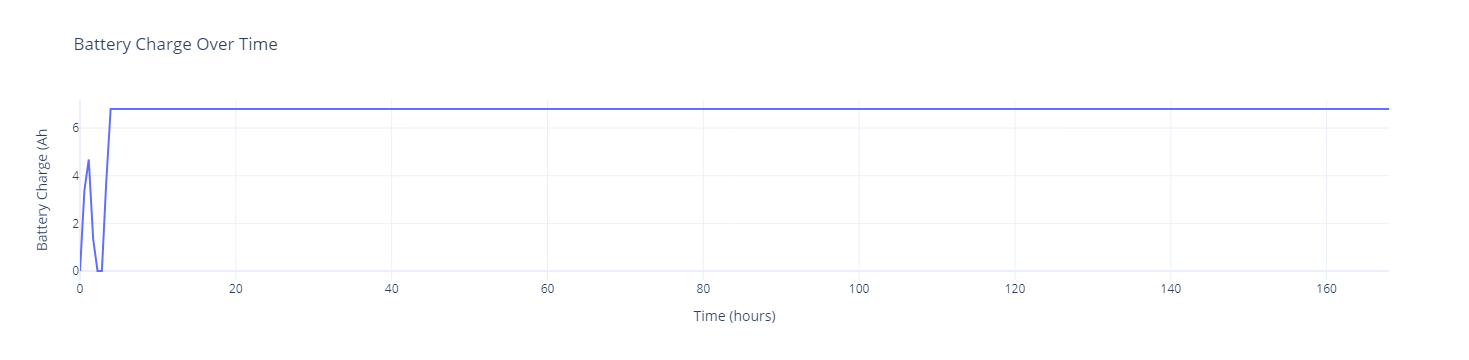

In [9]:
panel_count = solar_panel_count_min 
while panel_count <= solar_panel_count_max :
    #print("panel_count",panel_count)
    battery_count = battery_count_min
    while battery_count <= battery_count_max:
        #print("battery_count",battery_count)
        display(Markdown(f"# Trade Study one with following inputs"))
        display(Markdown(f" $$PanelCount =  {panel_count} $$"))
        display(Markdown(f" $$BatteryCount =  {battery_count} $$"))
        display(Markdown(f" $$SolarPanelPower= PanelPower * PanelCount =  {panel_power} * {panel_count} $$"))
        display(Markdown(f" $$BatteryCapacity = BatteryCapactiy * BatteryCount = { battery_capacity } * {battery_count} AH $$"))

        power_in_expr = power_generator(t, sun_period_value * 24/100, 24, 7*24,  panel_power*panel_count ,charger_eff)
        power_out_expr = battery_load(t , load_period_value*  24/100,  24,  7*24  ,boost_current_limit,boost_efficiency)
        #power_expr = power_in_expr -   power_out_expr
        #print(simplify(power_expr))

        
        # Substitute period value into the expression
        power_in_func = power_in_expr.subs(period, sun_period_value)
        power_out_func = power_out_expr.subs(period, sun_period_value)
        #power_func = power_expr.subs(period, sun_period_value)

        
        
        # Generate data for plotting
        t_vals = np.linspace(0, 7*24, 300)
        total_powers = []
        battery_powers =[]
        power_in = []
        power_out_desired = []
        power_out_delivered = []
        t_val_points = []
        battery_power =0 
        for t_val in t_vals:
            power_in_eval = power_in_func.evalf(subs={t: t_val})
            power_out_eval = power_out_func.evalf(subs={t: t_val})
            #panel_power_eval = power_func.evalf(subs={t: t_val})
            #battery_power= integrate(power_expr, (t, 0, t_val)).subs(period, period_value)
            #power_numerical_func = sp.lambdify(t, power_expr, "numpy")
            #battery_power, error = quad(power_numerical_func, 0, t_val, epsabs=1e-9, epsrel=1e-9)


            t_val_points.append(t_val)# for simpson
            power_in.append(float(power_in_eval))
            power_out_desired.append(float(power_out_eval))
            if battery_power <= 0 :
                power_out_delivered.append(float(0.0))
                total_powers.append(float(power_in_eval )) #had to covert to python float to elimnate TypeError: float() argument must be a string or a real number, not 'generator'
            else :
                power_out_delivered.append(float(power_out_eval))
                total_powers.append(float(power_in_eval - power_out_eval)) #had to covert to python float to elimnate TypeError: float() argument must be a string or a real number, not 'generator'
            battery_power= simpson( total_powers,  t_val_points)
            if battery_power >= battery_capacity + battery_count :
                battery_power = battery_capacity + battery_count
            if battery_power <  0  :
                battery_power = 0
            battery_powers.append(float(battery_power)) #had to covert to python float to elimnate TypeError: float() argument must be a string or a real number, not 'generator'
        print(f"Numerical Integration Result: {battery_power}")
        #print(f"Estimated Error: {error}")
        
        
        df = pd.DataFrame({'Time': t_vals,'Power In': power_in,'Power Out Desired':power_out_desired,'Power Out Delivered':power_out_delivered, 'Power':total_powers,'Battery Power':battery_powers})
        #print(df)
        fig = px.line(df, x='Time', y='Power In', title='Power Produced')
        
        fig.update_layout(xaxis_title='Time (hours)',
                           yaxis_title='Power (Watts)')
        # Show the plot
        fig.show()
 
        fig = px.line(df, x='Time',  y=[ 'Power Out Desired','Power Out Delivered'], title='Power Desired and Deliverede')
        
        fig.update_layout(xaxis_title='Time (hours)',
                           yaxis_title='Power (Watts)')
        # Show the plot
        fig.show()

        
        fig = px.line(df, x='Time', y='Power', title='Power Produced and Consumed Over Time')
        
        fig.update_layout(xaxis_title='Time (hours)',
                           yaxis_title='Power (Watts)')
        # Show the plot
        fig.show()
        
        
        fig = px.line(df, x='Time', y='Battery Power', title='Battery Charge Over Time')
        
        fig.update_layout(xaxis_title='Time (hours)',
                           yaxis_title='Battery Charge (Ah')
        # Show the plot
        fig.show()     
        battery_count = 1 + battery_count
    panel_count = 1 + panel_count
    
